In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree,metrics
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


In [94]:
data = pd.read_excel('DATACASE1.xlsx')
data=data.drop(columns=['FlightNumber'])
is_NaN = data.isnull();row_has_NaN = is_NaN.any(axis=1);rows_with_NaN = data[row_has_NaN]
data = data.drop(list(rows_with_NaN.index))
data=data.reset_index()
data.AircraftType=data.AircraftType.astype('str')

def apply_OneHotEncoder(data_col):
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = pd.DataFrame(enc.fit_transform(data_col).toarray())
    d={}
    for i in range (0,len(np.unique(data_col))):
        d[i]=enc.categories_[0][i]
    enc_df=enc_df.rename(columns=d)
    return enc_df

DateTime_dic = {'Month':[],'Year':[],'Hour':[],'Minute':[],'Day_Of_Year':[],'Day_Of_Week':[],
               'Is_month_end':[],'Is_month_start':[],'Quarter_end':[],'Quarter_start':[],'Year_end':[],
               'Year_Start':[],'Quarter':[]}

for a in data['ScheduleTime']:
    DateTime_dic['Month'].append(a.month);DateTime_dic['Year'].append(a.year)
    DateTime_dic['Hour'].append(a.hour);DateTime_dic['Minute'].append(a.minute);
    DateTime_dic['Day_Of_Year'].append(a.dayofyear);DateTime_dic['Day_Of_Week'].append(a.dayofweek);
    DateTime_dic['Is_month_end'].append(int(a.is_month_end));
    DateTime_dic['Is_month_start'].append(int(a.is_month_start));
    DateTime_dic['Quarter_end'].append(int(a.is_quarter_end));
    DateTime_dic['Quarter_start'].append(int(a.is_quarter_start));
    DateTime_dic['Year_end'].append(int(a.is_year_end));DateTime_dic['Year_Start'].append(int(a.is_year_start));
    DateTime_dic['Quarter'].append(a.quarter)
    
pd_time=pd.DataFrame.from_dict(DateTime_dic)
y=np.array(data.LoadFactor)
data=data.drop(columns='LoadFactor')

df = pd.concat([apply_OneHotEncoder(data[['Airline']]),apply_OneHotEncoder(data[['Destination']]),
                apply_OneHotEncoder(data[['AircraftType']]),apply_OneHotEncoder(data[['FlightType']]),
                apply_OneHotEncoder(data[['Sector']]),pd_time,pd.DataFrame(data.SeatCapacity)],axis=1)
                                                                          
X=np.array(df)

In [95]:
# NORMALIZATION
X_pre = X - np.mean(X,axis=0)
normalizer = preproc.Normalizer().fit(X_pre.T)  
X_pre = normalizer.transform(X_pre.T).T
min_max_scaler = preproc.MinMaxScaler()
y_pre = min_max_scaler.fit_transform(y.reshape(-1,1)).reshape(-1,)

In [96]:
# define feature selection
fs = SelectKBest(score_func=f_regression, k=386) # found to be the optimal num of features for random forest
# apply feature selection
X_selected = fs.fit_transform(X_pre, y)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)

In [98]:
y_test_idx=[list(y).index(el) for el in y_test]

In [99]:
model= RandomForestRegressor(n_estimators=100)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [100]:
y_pred=model.predict(X_test)

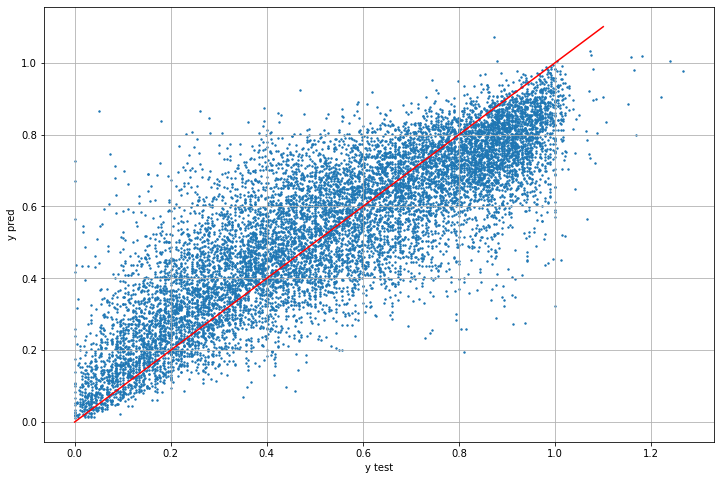

In [101]:
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

In [102]:
np.mean(np.abs((y_test-y_pred)))

0.11676486929568192

In [103]:
np.mean((y_test-y_pred)**2)

0.02290623908005474

In [104]:
Forecast_pass[0]

93.5360184331795

In [105]:
def estimated_total_accuracy(y,y_esti,SC_non_norm):
    #Deviation per flight = (Actual passengers – Forecasted passengers) / Actual passengers per flight
    #Accuracy per flight = 100% - | Deviation per flight |
    
    Actual_pass=np.array(y).T*SC_non_norm
    Forecast_pass=y_esti.T*SC_non_norm
    
    ind0=np.where(Actual_pass==0)[0]
    
    Actual_pass= np.delete(Actual_pass,ind0)
    Forecast_pass= np.delete(Forecast_pass,ind0)

    Dev= (np.abs(Actual_pass-Forecast_pass))/Actual_pass

    Exp_acc= 1-Dev
    T_exp_acc=np.mean(Exp_acc)*100

    return T_exp_acc


def compute_mse(X,beta,y):
    yhat = np.matmul(X, beta)
    res = (y - yhat) ** 2    
    mse = np.mean(res)
    
    return mse, res, yhat

In [106]:
SC_non_norm=np.array(data.SeatCapacity[y_test_idx])

In [107]:
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 58.55089544739571


### Compute accuracy using CV

In [110]:
K=5
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model= RandomForestRegressor(n_jobs=-1) # we leave all the values at DEFAULT
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)
    
np.mean(Accuracy)

Total Expected Accuracy: 8.064520647585551
Total Expected Accuracy: 45.01899035378919
Total Expected Accuracy: 23.112385390745178
Total Expected Accuracy: 26.29598156032434
Total Expected Accuracy: 52.10425079641028


30.91922574977091